In [6]:
import numpy as np
import optuna
from sklearn import metrics
import warnings
import pickle
warnings.simplefilter(action='ignore', category=FutureWarning)
import joblib
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pyswarm import pso
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, r2_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import log_loss

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [7]:
XGB_Model_Path = "Classification/xgb_model.json"
LGB_Model_Path = "Classification/lgb_model.txt"

# 加载模型
bst = xgb.Booster()
bst.load_model(XGB_Model_Path)
gbm = lgb.Booster(model_file=LGB_Model_Path)

In [8]:
# Load the data
data = np.load('DataSet/Classified_Data.npz')

Features = data['features']

Labels = data['labels']

print(Features.shape, Labels.shape)

(16871, 9) (16871,)


In [9]:
# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size=0.2, random_state=42)

# 创建 LightGBM 数据集
XGB_train = xgb.DMatrix(X_train, label=y_train)
XGB_dtest = xgb.DMatrix(X_test, label=y_test)

# 创建 LightGBM 数据集
LGB_train_data = lgb.Dataset(X_train, label=y_train)
LGB_test_data = lgb.Dataset(X_test, label=y_test, reference=LGB_train_data)


In [10]:
# 使用 XGBoost 模型获取预测概率
preds_xgb = bst.predict(XGB_dtest)

# 使用 LightGBM 模型获取预测概率
preds_lgb = gbm.predict(X_test)

In [11]:
# 简单平均的权重
weight_xgb = 0.5
weight_lgb = 0.5

# 计算加权平均的预测概率
preds_average = weight_xgb * preds_xgb + weight_lgb * preds_lgb

In [12]:
y_pred = (preds_average >= 0.5).astype(int)

# 输出分类报告和准确度
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1872
           1       0.87      0.92      0.90      1503

    accuracy                           0.90      3375
   macro avg       0.90      0.91      0.90      3375
weighted avg       0.91      0.90      0.90      3375

Accuracy: 0.9034074074074074


In [13]:
def objective(weights):
    # 检查权重和，避免除以零
    weight_sum = sum(weights)
    if weight_sum == 0:
        return float('inf')

    # 归一化权重以确保它们的和为1且非负
    normalized_weights = np.array(weights) / weight_sum

    # 计算加权平均预测概率
    preds = (normalized_weights[0] * bst.predict(XGB_dtest, output_margin=False, iteration_range=(0, bst.best_iteration + 1)) +
             normalized_weights[1] * gbm.predict(X_test, num_iteration=gbm.best_iteration))
    return log_loss(y_test, preds)

# 粒子群优化
lb = [0, 0]  # 权重下界
ub = [1, 1]  # 权重上界
xopt, fopt = pso(objective, lb, ub, swarmsize=50, maxiter=100)

print("Optimal weights:", xopt)
print("Optimal log loss:", fopt)

Stopping search: Swarm best objective change less than 1e-08
Optimal weights: [0.88149893 0.20993251]
Optimal log loss: 0.23375707308838933


In [14]:
# 使用 XGBoost 模型获取预测概率
preds_xgb = bst.predict(XGB_dtest, output_margin=False, iteration_range=(0, bst.best_iteration + 1))

# 使用 LightGBM 模型获取预测概率
preds_lgb = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [15]:
# 应用优化后的权重（归一化处理）
weights = np.array(xopt)
normalized_weights = weights / np.sum(weights)

# 计算加权平均预测概率
combined_preds = normalized_weights[0] * preds_xgb + normalized_weights[1] * preds_lgb

In [16]:
y_pred = (combined_preds >= 0.5).astype(int)

# 输出分类报告和准确度
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1872
           1       0.86      0.93      0.89      1503

    accuracy                           0.90      3375
   macro avg       0.90      0.90      0.90      3375
weighted avg       0.90      0.90      0.90      3375

Accuracy: 0.9025185185185185


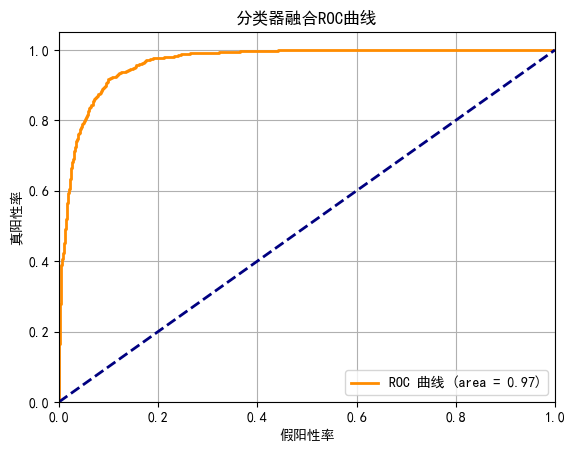

In [18]:
from sklearn.metrics import roc_curve, auc
# 计算 ROC 曲线的 FPR（假阳性率）和 TPR（真阳性率）
fpr, tpr, thresholds = roc_curve(y_test, combined_preds)  # 注意: y_pred_prob 需要是预测为正类的概率
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC 曲线 (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.title('分类器融合ROC曲线')
plt.legend(loc="lower right")
plt.grid()
plt.show()


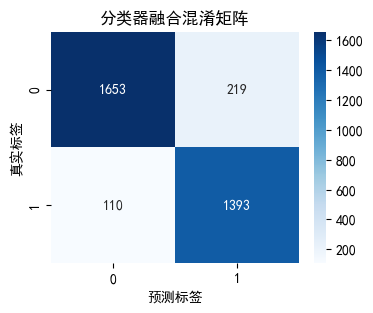

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 使用 Seaborn 绘图
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('分类器融合混淆矩阵')
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.show()